Loading Timit Training Dataset using DeepLake

In [1]:
!pip install "deeplake<4"
!pip install av
!pip install deeplake[audio]

import deeplake
Training_Data_Set = deeplake.load("hub://activeloop/timit-train")

/usr/local/lib/python3.10/dist-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (4.0.3) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(
\

Opening dataset in read-only mode as you don't have write permissions.


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/timit-train



-

hub://activeloop/timit-train loaded successfully.



Citation

In [ ]:
'''
CITATION
@inproceedings,
  title = {TIMIT Acoustic-Phonetic Continuous Speech Corpus},
  author = {John S. Garofolo, Lori F. Lamel, William M. Fisher, Jonathan G. Fiscus, David S. Pallett, Nancy L. Dahlgren, Victor Zue},
  booktitle = {Linguistic Data Consortium, },
  year = {1993}
}
'''

Transforming waveforms to spectograms

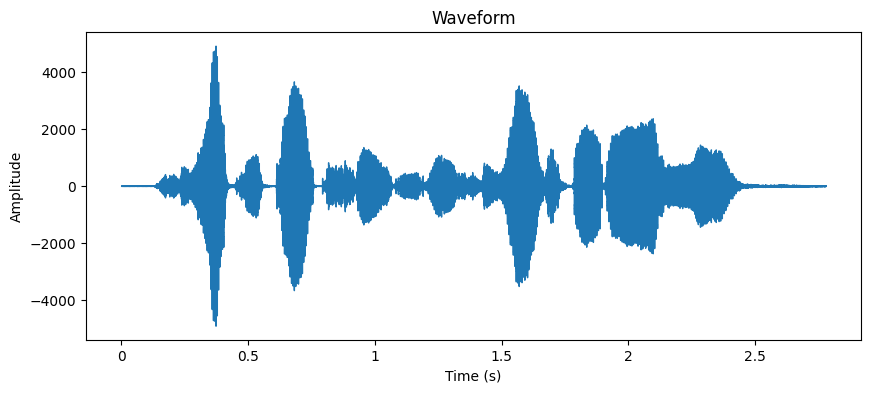

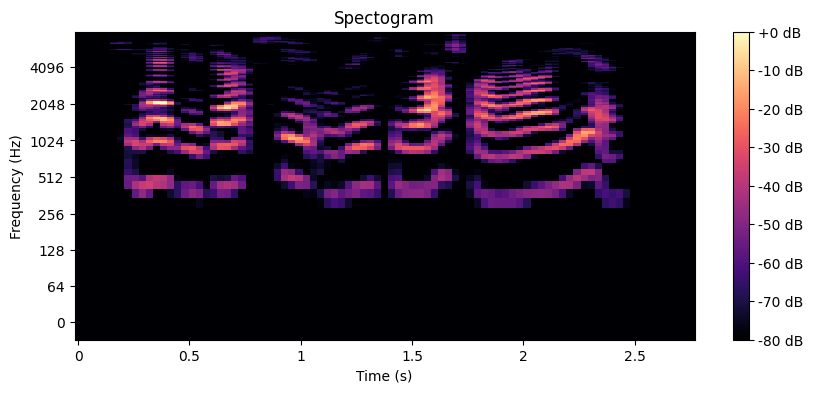

['She had your dark suit in greasy wash water all year.']


In [8]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import librosa.display

sample = Training_Data_Set[1]  #access the first sample


#access the audio waveform from the 'audios' tensor
def process_timit_sample(sample):

    audio = sample['audios'].numpy() #extract the audio waveform as a NumPy array
    texts = sample['texts'].numpy() #extract the corresponding text

    sr = 16000 #TIMIT dataset has a 16kHz sample rate
    if len(audio.shape) > 1:
            audio = audio.flatten()

    #plot the waveform
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(audio, sr=sr)
    plt.title('Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)
    mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)  # Convert to decibel scale

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.show()

    print(texts)

process_timit_sample(sample)


We apply normalization to set values between 1 and 0



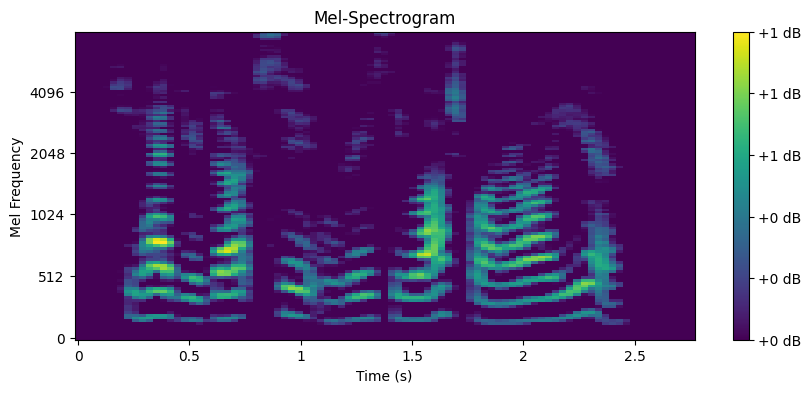

In [29]:
import librosa
import librosa.display
import numpy as np

sr = 16000 #TIMIT dataset has a 16kHz sample rate

#Function to get Mel-spectrogram 2D array
def mel_spectrogram2d(sample):
    audio = sample['audios'].numpy()  #Extract the audio waveform as a NumPy array
    if len(audio.shape) > 1:
        audio = audio.flatten()

    #Compute Mel-spectrogram
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)
    mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)  #Convert to decibel scale

    return normalize_melspectogram(mel_spec_db)

#Function to get label
def get_label(sample):
    text = sample['texts'].numpy()  #Extract the text as a NumPy array
    return text.item()  #Convert the NumPy scalar to a standard Python string



#Function to normalize melspectogram to set values between 0 and 1 db
def normalize_melspectogram(mel_spec):
    min_val = np.min(mel_spec)
    max_val = np.max(mel_spec)
    return (mel_spec - min_val) / (max_val - min_val)

#Generate Mel-spectrogram
normalized_mel_spectrogram = mel_spectrogram2d(sample)


#Plot the Mel-spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(normalized_mel_spectrogram, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Mel Frequency')
plt.show()






Creating mappings from numbers to letters.

Note: Our model will have a softmax layer that gives us the output it won't map to letters it gives us a number so we will map these numbers to characters to give them meaning. the characters are all letters in the alphabet + a blank   (" "). We will be using a dictionary.


Once we were adding padding we ran into a problem which is our dictionary does not account for capital letters so we have two options either add capital letters to our dictionary which will take more time to looku up and more space or remove capital letters all together as we are not in need of them. We went with the decision to remove capital letters as it would be simpler and we do not need the capital letters the message is understandable without them also we removed punctuation for the same reason.


Additional note we need the labels in ids not in chars since our rnn output is ids.

In [25]:
#Dictionary that has keys nbs from 0 to 26 and values the letters a->z + ' ' as value for key 26.   We are using the ascii values thats what char(97+i) is doing
id_to_char = {i: chr(97 + i) if i < 26 else ' ' for i in range(27)}


#Inverting the dictionary
char_to_id = {v: k for k, v in id_to_char.items()}

#Char to id function
def transcription_to_ids(transcription):
    return [char_to_id[char] for char in transcription]


#id to char function
def ids_to_transcription(transcription):
    return [id_to_char[id] for id in transcription]


#Testing both functions
print(transcription_to_ids('hello world'))

print(ids_to_transcription([7, 4, 11, 11, 14, 26, 22, 14, 17, 11, 3]))



[7, 4, 11, 11, 14, 26, 22, 14, 17, 11, 3]
['h', 'e', 'l', 'l', 'o', ' ', 'w', 'o', 'r', 'l', 'd']


Our training inputs vary in length. This makes sense since not all voice recordings are the same length. BUT this doesnt allow us to train using batches since they all should have the same dimension. To solve this we will be adding padding to make all inputs equal in length. Small problem is that this introduces computation overhead, to reduce it we will use masking to indicate which of the data is padded and what is real data. Note that there still is computation overhead but we will go with it because using batching makes training faster especially since we are working with a big dataset. (We also need to do the same for the ouputs as well)


To explain what is happening for spectograms and text sequences we are adding -1 as padding

for the mask we check if we have -1 values if we do we know these arent real data since for both melspectograms and text seq we have no -ve values (normalization bw 0 and 1 for spectogram and for text seq values are between 0->26) we label fake data with 0s and real data with 1s

In [46]:
import string

#adding padding to spectograms
def pad_spectrograms(spectrograms):
    #Find the maximum time steps in the batch
    max_time_steps = max(s.shape[1] for s in spectrograms)

    #Pad each spectrogram with zeros along the time axis
    padded_spectrograms = [
        np.pad(s, ((0, 0), (0, max_time_steps - s.shape[1])), mode="constant", constant_values=-1)
        for s in spectrograms
    ]
    return np.array(padded_spectrograms)


#Adding padding to lables
def pad_text_sequences(sequences):
    # Find the maximum sequence length
    max_length = max(len(seq) for seq in sequences)

    # Pad each sequence with the padding value
    padded_sequences = [
        seq + [-1] * (max_length - len(seq))
        for seq in sequences
    ]
    return np.array(padded_sequences)

#transforms upper case characters to lower case and removes punctuation
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    return text


#function to get spectograms from batch
def get_spectograms(batch):
    return [mel_spectrogram2d(sample) for sample in batch]

#function to get labels in ids instead of text from batch
def get_labels_transformed_to_ids(batch):
    text_sequences=[get_label(sample) for sample in batch]
    text_sequences_without_capital_letters=[preprocess_text(text) for text in text_sequences]
    return [transcription_to_ids(sample) for sample in text_sequences_without_capital_letters]


#Testing
batch=[Training_Data_Set[0],Training_Data_Set[1],Training_Data_Set[2]]

spectograms=get_spectograms(batch)
text_sequences=get_labels_transformed_to_ids(batch)

print(spectograms)
print(text_sequences)

print(pad_spectrograms(spectograms))
print(pad_text_sequences(text_sequences))



#Adding masking
def create_spectrogram_mask(spectrograms):
    #A time step is valid if all its frequency bins are non-zero
    return (spectrograms != -1).astype(np.float32)

def create_text_mask(sequences):
    #Our output doesnt include -1 remeber out valid outputs are 0-26
    return (sequences != -1).astype(np.float32)


print(create_spectrogram_mask(pad_spectrograms(spectograms)))
print(create_text_mask(pad_text_sequences(text_sequences)))


[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])]
[[15, 20, 1, 11, 8, 2, 8, 19, 24, 26, 0, 13, 3, 26, 13, 14, 19, 14, 17, 8, 4, 19, 24, 26, 6, 14, 26, 7, 0, 13, 3, 26, 8, 13, 26, 7, 0, 13, 3], [18, 7, 4, 26, 7, 0, 3, 26, 24, 14, 20, 17, 26, 3, 0, 17, 10, 26, 18, 20, 8, 19, 26, 8, 13, 26, 6, 17, 4, 0, 18, 24, 26, 22, 0, 18